In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ptype.data import load_ptype_data_subset
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
def load_ptype_data_subset(
    data_path, source, start_date, end_date, n_jobs=1, verbose=1
):
    """
    Load a single range of dates from the mPING or ASOS parquet files into memory. Supports parallel loading with joblib.

    Args:
        data_path: Path to appropriate p-type directory containing parquet files.
        source: "mPING" or "ASOS"
        start_date: Pandas-supported Date string for first day in time range (inclusive)
        end_date: Pandas supported Date string for last day in time range (inclusive)
        n_jobs: Number of parallel processes to use for data loading (default 1)
        verbose: verbose level
    Returns:
        data: Pandas DataFrame containing all sounding and p-type data from start_date to end_date.

    """
    start_timestamp = pd.Timestamp(start_date)
    end_timestamp = pd.Timestamp(end_date)
    data_files = sorted(os.listdir(data_path))
    all_dates = pd.DatetimeIndex([x[-16:-8] for x in data_files])
    selected_dates = all_dates[
        (all_dates >= start_timestamp) & (all_dates <= end_timestamp)
    ]
    dfs = []
    if n_jobs == 1:
        for date in tqdm(selected_dates):
            date_str = date.strftime("%Y%m%d")
            filename = f"{source}_rap_{date_str}.parquet"
            dfs.append(pd.read_parquet(os.path.join(data_path, filename)))
    else:
        date_strs = selected_dates.strftime("%Y%m%d")
        dfs = Parallel(n_jobs=n_jobs, verbose=verbose)(
            [
                delayed(pd.read_parquet)(
                    os.path.join(data_path, f"{source}_rap_{date_str}.parquet")
                )
                for date_str in date_strs
            ]
        )
    data = pd.concat(dfs, ignore_index=True)
    return data

In [7]:
"mPING_rap_20160112.parquet"[-16:-8]

'20160112'

In [62]:
data_path = "/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap_archive/mPING_mixture/"
source = "mPING"
start_date = pd.Timestamp("20130101")
end_date = pd.Timestamp("20210430")
ptype_data = load_ptype_data_subset(data_path, 
                                    source, start_date, end_date, n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 344 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 844 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 1544 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 2444 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 2492 out of 2499 | elapsed:   52.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 2499 out of 2499 | elapsed:   52.3s finished


In [63]:
mping_ptype = ptype_data[["ra_percent", "sn_percent", "pl_percent", "fzra_percent"]]

In [64]:
rap_ptype = ptype_data[["CRAIN_-", "CSNOW_-", "CICEP_-", "CFRZR_-"]]

In [65]:
mping_one_ptype = np.zeros(mping_ptype.shape, dtype=int)
mping_one_ptype[np.arange(mping_ptype.shape[0]), mping_ptype.values.argmax(axis=1)] = 1

In [66]:
idx = rap_ptype.sum(axis=1) > 0


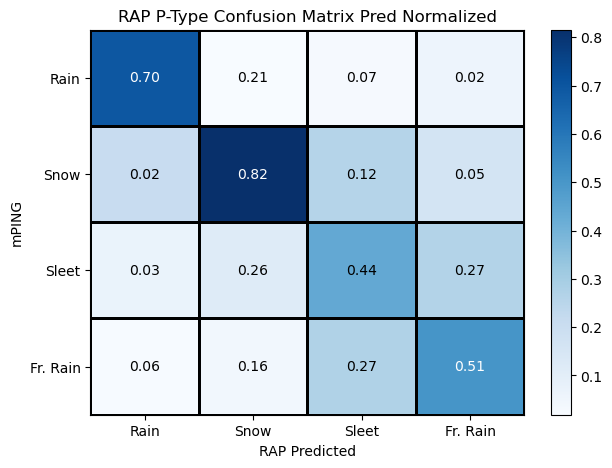

In [80]:
rap_cm_pred = confusion_matrix(mping_one_ptype[idx].argmax(axis=1), rap_ptype[idx].values.argmax(axis=1), 
                          normalize="pred")
plt.figure(figsize=(7, 5))
plt.pcolormesh(rap_cm_pred, cmap="Blues", edgecolor='k')
plt.gca().invert_yaxis()
ptypes = ["Rain", "Snow", "Sleet", "Fr. Rain"]
for (i, j), v in np.ndenumerate(rap_cm_pred):
    if v > 0.5:
        color = 'w'
    else:
        color = 'k'
    plt.text(i + 0.5, j + 0.5, f"{v:0.2f}", ha='center', va='center', color=color)
plt.xticks(np.arange(0.5, 4.5), ptypes)
plt.yticks(np.arange(0.5, 4.5), ptypes)
plt.colorbar()
plt.title("RAP P-Type Confusion Matrix Pred Normalized")
plt.xlabel("RAP Predicted")
plt.ylabel("mPING")
plt.savefig("rap_cm_pred.png", dpi=200, bbox_inches="tight")

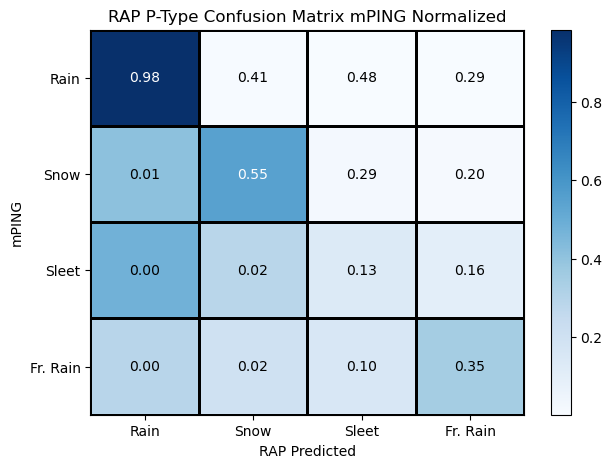

In [81]:
rap_cm_true = confusion_matrix(mping_one_ptype[idx].argmax(axis=1), rap_ptype[idx].values.argmax(axis=1), 
                          normalize="true")
plt.figure(figsize=(7, 5))
plt.pcolormesh(rap_cm_true, cmap="Blues", edgecolor='k')
plt.gca().invert_yaxis()
ptypes = ["Rain", "Snow", "Sleet", "Fr. Rain"]
for (i, j), v in np.ndenumerate(rap_cm_true):
    if v > 0.5:
        color = 'w'
    else:
        color = 'k'
    plt.text(i + 0.5, j + 0.5, f"{v:0.2f}", ha='center', va='center', color=color)
plt.xticks(np.arange(0.5, 4.5), ptypes)
plt.yticks(np.arange(0.5, 4.5), ptypes)
plt.colorbar()
plt.title("RAP P-Type Confusion Matrix mPING Normalized")
plt.xlabel("RAP Predicted")
plt.ylabel("mPING")
plt.savefig("rap_cm_true.png", dpi=200, bbox_inches="tight")

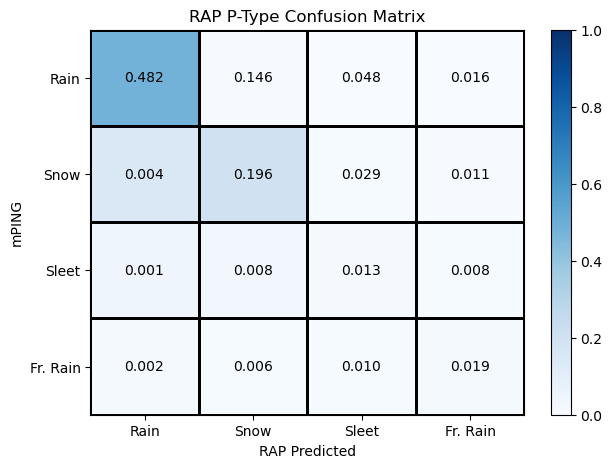

In [82]:
rap_cm_all = confusion_matrix(mping_one_ptype[idx].argmax(axis=1), rap_ptype[idx].values.argmax(axis=1), 
                          normalize="all")
plt.figure(figsize=(7, 5))
plt.pcolormesh(rap_cm_all, cmap="Blues", edgecolor='k', vmin=0, vmax=1)
plt.gca().invert_yaxis()
ptypes = ["Rain", "Snow", "Sleet", "Fr. Rain"]
for (i, j), v in np.ndenumerate(rap_cm_all):
    if v > 0.5:
        color = 'w'
    else:
        color = 'k'
    plt.text(i + 0.5, j + 0.5, f"{v:0.3f}", ha='center', va='center', color=color)
plt.xticks(np.arange(0.5, 4.5), ptypes)
plt.yticks(np.arange(0.5, 4.5), ptypes)
plt.colorbar()
plt.title("RAP P-Type Confusion Matrix")
plt.xlabel("RAP Predicted")
plt.ylabel("mPING")
plt.savefig("rap_cm_all.png", dpi=200, bbox_inches="tight")

In [12]:
list(ptype_data.columns)

['datetime',
 'lat',
 'lon',
 'report_count',
 'ra_percent',
 'sn_percent',
 'pl_percent',
 'fzra_percent',
 'CFRZR_-',
 'CICEP_-',
 'CRAIN_-',
 'CSNOW_-',
 'DEWPOINT_2M_C',
 'DEWPOINT_DEPRES_2M_C',
 'EL_HGT_m',
 'HGT_1000_m',
 'HGT_100_m',
 'HGT_125_m',
 'HGT_150_m',
 'HGT_175_m',
 'HGT_200_m',
 'HGT_225_m',
 'HGT_250_m',
 'HGT_275_m',
 'HGT_300_m',
 'HGT_325_m',
 'HGT_350_m',
 'HGT_375_m',
 'HGT_400_m',
 'HGT_425_m',
 'HGT_450_m',
 'HGT_475_m',
 'HGT_500_m',
 'HGT_525_m',
 'HGT_550_m',
 'HGT_575_m',
 'HGT_600_m',
 'HGT_625_m',
 'HGT_650_m',
 'HGT_675_m',
 'HGT_700_m',
 'HGT_725_m',
 'HGT_750_m',
 'HGT_775_m',
 'HGT_800_m',
 'HGT_825_m',
 'HGT_850_m',
 'HGT_875_m',
 'HGT_900_m',
 'HGT_925_m',
 'HGT_950_m',
 'HGT_975_m',
 'HGT_ON_0CISOTHM_m',
 'HGT_ON_SFC_m',
 'MEAN_SEA_LEVEL_Pa',
 'POT_TEMP_2M_C',
 'PRES_ON_0CISOTHM_Pa',
 'PRES_ON_SURFACE_Pa',
 'RH_1000_percent',
 'RH_100_percent',
 'RH_125_percent',
 'RH_150_percent',
 'RH_175_percent',
 'RH_200_percent',
 'RH_225_percent',
 'RH_250_